In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.hidden1 = nn.Linear(17, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.3)  # Increased dropout
        
        self.hidden2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.hidden3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.hidden4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.relu4 = nn.ELU()
        
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.hidden1(x))))
        x = self.dropout2(self.relu2(self.batch_norm2(self.hidden2(x))))
        x = self.dropout3(self.relu3(self.batch_norm3(self.hidden3(x))))
        x = self.relu4(self.batch_norm4(self.hidden4(x)))
        x = self.output(x)
        return x


# Initialize the model
model = RegressionModel()

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adjusted weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)


In [47]:
# Data Preparation
df = pd.read_csv('../Data/dataset83.csv')
df.drop(['Year_start', 'Year_end'], axis='columns', inplace=True)

In [48]:
df['wing_loading'].head()

0    1.914
1    1.928
2    1.908
3    1.860
4    1.886
Name: wing_loading, dtype: object

In [49]:
label_encoder = LabelEncoder()

df['Species'] = label_encoder.fit_transform(df['Species'])
df['Population'] = label_encoder.fit_transform(df['Population'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])

# Converting a column to float
df['Thorax_length'] = pd.to_numeric(df['Thorax_length'], errors='coerce').astype('float64')

# Converting a column to int (after ensuring it's first converted to float to handle non-integer formats)
df['wing_loading'] = pd.to_numeric(df['wing_loading'], errors='coerce').astype('float64')



for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        # Fill missing values with mean for numerical columns
        col_mean = df[col].mean()
        df[col] = df[col].fillna(col_mean)
    elif df[col].dtype == 'object':
        # Fill missing values with mode for categorical columns
        col_mode = df[col].mode()[0]
        df[col] = df[col].fillna(col_mode)

In [50]:
df.dtypes

Species            int64
Population         int64
Latitude         float64
Longitude        float64
Temperature        int64
Vial               int64
Replicate          int64
Sex                int64
Thorax_length    float64
l2               float64
l3p              float64
l3d              float64
lpd              float64
l3               float64
w1               float64
w2               float64
w3               float64
wing_loading     float64
dtype: object

In [51]:
df['wing_loading'].head()

0    1.914
1    1.928
2    1.908
3    1.860
4    1.886
Name: wing_loading, dtype: float64

Epoch 1/1000 - Train Loss: 2.6966, Val Loss: 2.2404
Epoch 2/1000 - Train Loss: 1.8739, Val Loss: 1.5612
Epoch 3/1000 - Train Loss: 1.1703, Val Loss: 0.8233
Epoch 4/1000 - Train Loss: 0.6091, Val Loss: 0.3860
Epoch 5/1000 - Train Loss: 0.2668, Val Loss: 0.1161
Epoch 6/1000 - Train Loss: 0.1120, Val Loss: 0.0367
Epoch 7/1000 - Train Loss: 0.0653, Val Loss: 0.0184
Epoch 8/1000 - Train Loss: 0.0561, Val Loss: 0.0109
Epoch 9/1000 - Train Loss: 0.0488, Val Loss: 0.0137
Epoch 10/1000 - Train Loss: 0.0470, Val Loss: 0.0080
Epoch 11/1000 - Train Loss: 0.0406, Val Loss: 0.0056
Epoch 12/1000 - Train Loss: 0.0407, Val Loss: 0.0062
Epoch 13/1000 - Train Loss: 0.0369, Val Loss: 0.0044
Epoch 14/1000 - Train Loss: 0.0376, Val Loss: 0.0058
Epoch 15/1000 - Train Loss: 0.0366, Val Loss: 0.0086
Epoch 16/1000 - Train Loss: 0.0333, Val Loss: 0.0044
Epoch 17/1000 - Train Loss: 0.0296, Val Loss: 0.0077
Epoch 18/1000 - Train Loss: 0.0326, Val Loss: 0.0044
Epoch 19/1000 - Train Loss: 0.0341, Val Loss: 0.0071
Ep

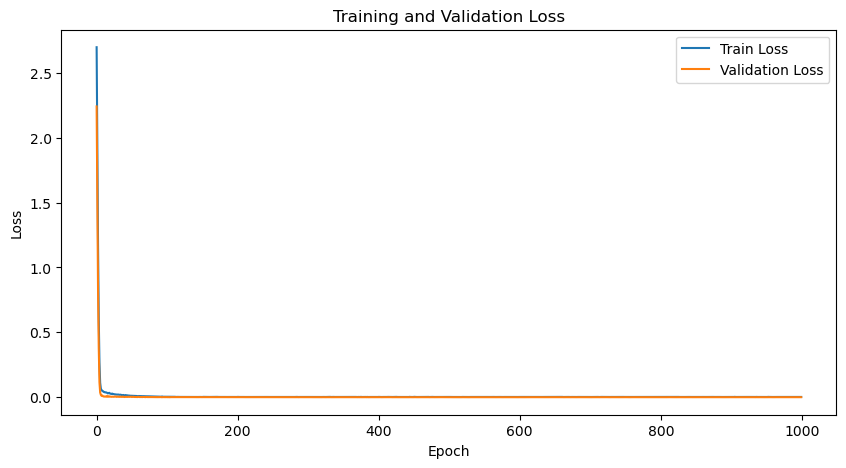

In [52]:
X = df.drop('wing_loading', axis=1).values
y = df['wing_loading'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=69)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Adjusting the learning rate scheduler initialization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

num_epochs = 1000
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate_epoch(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Update the learning rate scheduler with the latest validation loss
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Loss: 0.0004


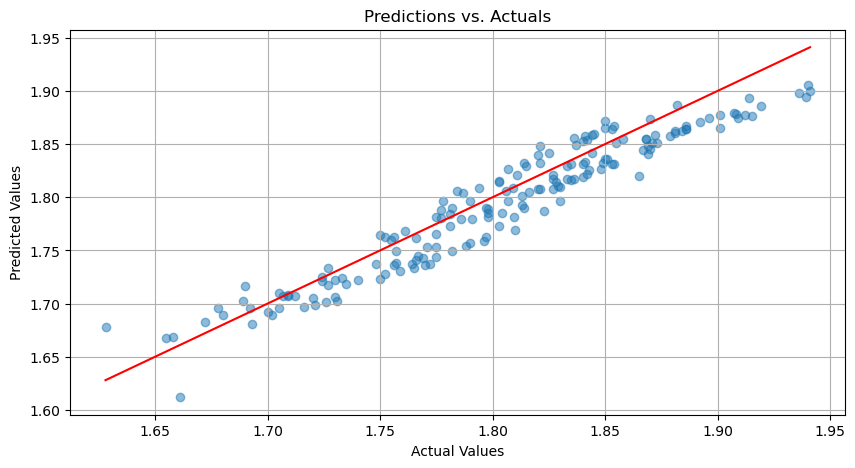

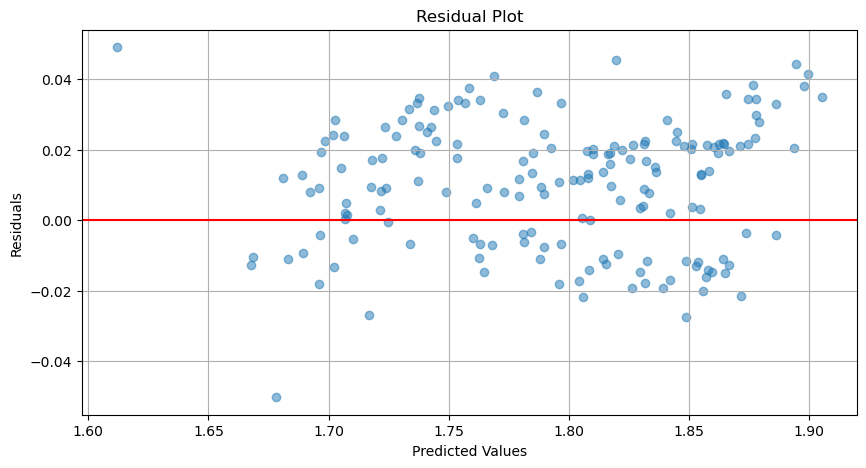

In [53]:
# Evaluate the model on the test dataset
test_loss = validate_epoch(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')

# Predictions vs. Actual plot
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(labels.view(-1).tolist())

plt.figure(figsize=(10, 5))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r')  # Line showing perfect predictions
plt.title('Predictions vs. Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Residual Plot
residuals = [act - pred for act, pred in zip(actuals, predictions)]
plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [55]:
# Making predictions
from sklearn.metrics import mean_squared_error, r2_score
# Calculate R^2 and MSE
test_mse = mean_squared_error(actuals, predictions)
test_r2 = r2_score(actuals, predictions)

print(f"Test MSE: {test_mse}")
print(f"Test R^2: {test_r2}")

Test MSE: 0.00042896663701027274
Test R^2: 0.9004371181934496


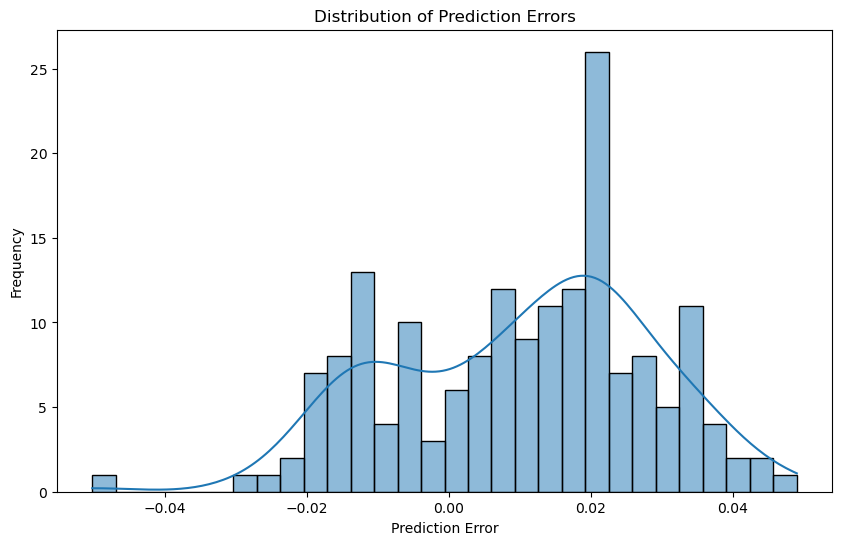

In [57]:
import seaborn as sns 

errors = residuals  # Which are y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()